<h1 align='center'>ENGC63 - 3º Projeto</h1>

**Universidade Federal da Bahia - UFBA**

**Disciplina :** Processamento Digital de Sinais

**Discentes :** Miguel Feliciano Mota Alves e Rodrigo Freitas Sá Barretto

## Introdução

A janela de kaiser é definida por:

$$
w[n] = 
\begin{cases}
\displaystyle
\frac{I_0[\beta(1-[\frac{(n-\alpha)}{\alpha}]^2)^{1/2}]}{I_0(\beta)}\\
0, & \text{caso contrário}
\end{cases}
$$

onde $\alpha = M/2$ e $I_0(\cdot)$ é a função de Besel modificada.

Para implementar o filtro FIR utilizando a **janela de Kaiser**, diferentemente dos outros tipos de janela, primeiro define-se as especificações do filtro desejado e, com as especificações definidas, calcula-se os parâmetros da janela $\beta$ e $M$ da janela.

## Dados do Projeto

A seguir estão as especificações definidas para o projeto do filtro.

### 1. Especificações de Frequência

Com uma frequência de corte central ($\omega_c$) e uma largura de banda de transição ($\Delta\omega$) definidas, as frequências da banda de passagem ($\omega_p$) e da banda de rejeição ($\omega_s$) podem ser encontradas a partir delas.

* **Frequência de Corte Central ($\omega_c$):**
    $$\omega_c = \frac{\pi}{2} \text{ rad/amostra}$$

* **Largura da Banda de Transição ($\Delta\omega$):**
    $$\Delta\omega = 0.1\pi \text{ rad/amostra}$$

* **Banda de Passagem:** O filtro deve passar frequências no intervalo $[0, \omega_p]$, $\omega_p = \omega_c - (\Delta\omega/2)$.
    $$0 \le \omega \le 0.45\pi \text{ rad/amostra}$$

* **Banda de Rejeição:** O filtro deve rejeitar frequências no intervalo $[\omega_s, \pi]$, $\omega_s = \omega_c + (\Delta\omega/2)$, até $\pi$.
    $$0.55\pi \le \omega \le \pi \text{ rad/amostra}$$

### 2. Ripple e Atenuação

Como, para o projeto por janela, o filtro resultante terá o mesmo erro de pico na banda de passagem e na banda de rejeição, isto é, $\delta_p = \delta_s$ e a atenuação na banda de rejeição pode ser definida por:

$$A_s = -20 \log_{10}(|H(e^{j\omega})|) \ge 50 \text{ dB}$$

portanto:

$$\delta_p = \delta_s \approx 0.00316$$

### 3. Intervalos de Tolerância

Com base nas especificações de frequência e nos valores de *ripple* definidos, os intervalos de tolerância para a magnitude da resposta em frequência, $|H(e^{j\omega})|$, são os seguintes:

* **Na Banda de Passagem ($0 \le \omega \le 0.45\pi$):** O ganho deve estar dentro do seguinte intervalo: 
    $$0.99684 \le |H(e^{j\omega})| \le 1.00316$$

* **Na Banda de Rejeição ($0.55\pi \le \omega \le \pi$):** O ganho deve ser suprimido para o seguinte intervalo:
    $$ 0 \le |H(e^{j\omega})| \le 0.00316$$

In [53]:
from scipy.signal import kaiserord, firwin, freqz, tf2sos, sosfreqz
import numpy as np
import matplotlib.pyplot as plt

## 1. Criação do Filtro

### Definição das Variáveis do Filtro

In [54]:
w_cutoff = np.pi / 2                  # Frequência de corte [rad/amostra]
w_transition = 0.1 * np.pi            # Região de transição [rad/amostra]
A = 50                                # Atenuação [dB]
w_pass = w_cutoff - w_transition/2    # Banda de passagem [rad/amostra]
w_stop = w_cutoff + w_transition/2    # Banda de rejeição [rad/amostra]
erro = 0.00316                        # Erro máximo

print(f'Frequência de corte: {w_cutoff/np.pi}π')
print(f'Região de transição: {w_transition/np.pi}π')
print(f'Banda de passagem: {w_pass/np.pi}π')
print(f'Banda de rejeição: {w_stop/np.pi}π')
print(f'Atenuação: {A} dB')
print(f'Erro máximo: {erro}')

Frequência de corte: 0.5π
Região de transição: 0.1π
Banda de passagem: 0.45π
Banda de rejeição: 0.55π
Atenuação: 50 dB
Erro máximo: 0.00316


### Definição de Parâmetros da Janela de Kaiser

In [55]:
M, beta = kaiserord(A, w_transition / np.pi) # Calcula a ordem e o beta da janela kaiser
print(f'Ordem do filtro: {M}')
print(f'β = {beta}')

Ordem do filtro: 60
β = 4.533514120981248


Para este projeto, a ordem escolhida do filtro será PAR, para que o filtro projetado seja de tipo 1 e não imponha restrições. Isso é essencial para uma etapa futura do trabalho, onde serão feitas transformações do filtro passa-baixas para outros tipos de filtro (e.g. passa-altas). Se outros tipos de filtro fossem utilizados, as restrições existentes para esses tipos poderiam levar a resultados indesejados.

### Criação do Filtro

In [56]:
'''
1 - numtaps = Ordem(FIR) + 1, se M é par, numtaps é impar
2 - Cria o filtro usando a janela Kaiser
3 - Cutoff precisa ser normalizado
4 - Por padrão a biblioteca scipy implementa o filtro na forma direta
''' 
fir_direct = firwin(numtaps=M+1, cutoff=w_cutoff / np.pi, window=('kaiser', beta), pass_zero='lowpass')

## 2. Análise do Filtro com Precisão Infinita

In [57]:
# Convenção para nome de variáveis
# X : Forma (direta ou cascata)
# Y : Número de casas decimais (Caso não seja definido, considerado 'infinito')

def calculate_variables(omega_X_norm_Y, response_X_Y):
    response_mag = abs(response_X_Y)                           # |H(e^jw)|
    response_dB = 20 * np.log10(abs(response_X_Y))             # Resposta em dB
    phase = np.unwrap(np.angle(response_X_Y))                  # Fase unwraped
    group_delay = -np.gradient(phase, omega_X_norm_Y * np.pi)  # Atraso de grupo
    
    return response_mag, response_dB, phase, group_delay

def plot_graphs(omega_X_norm_Y, response_X_Y, form:str, precision:str, gd_flag: bool = False):
    
    response_mag, response_dB, phase, group_delay = calculate_variables(omega_X_norm_Y, response_X_Y)

    # Filtro passa-baixas ideal para comparação e cálculo de erro
    lpf_ideal = np.where(omega_X_norm_Y <= w_cutoff / np.pi, 1.0, 0.0) 

    if gd_flag:
        linhas = 4
        altura = 16
    else:
        linhas = 3
        altura = 13
        
    
    fig, axes = plt.subplots(linhas, 1, figsize=(14, altura))

    # Gráfico 1: |H(e^jw)|
    axes[0].plot(omega_X_norm_Y, response_mag, label='Resposta Passa-Baixas Kaiser', color='blue', linewidth=2)
    axes[0].plot(omega_X_norm_Y, lpf_ideal, color='orange', linestyle='--', linewidth=1.3, label='LPF Ideal')
    axes[0].set_title('Magnitude X Resposta Ideal')
    axes[0].set_xlabel('Frequência Normalizada (ω / π)')
    axes[0].set_ylabel('|H(e^jw)|')
    axes[0].set_xticks(np.arange(0, 1.05, 0.05))
    axes[0].set_xlim(0, 1.0)
    axes[0].set_ylim(-0.05, 1.1)
    axes[0].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
    axes[0].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
    axes[0].axvspan(0.45, 0.55, color='gray', alpha=0.2, label='Região de Transição')
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
    axes[0].legend()

    # Gráfico 2: Ganho em dB
    axes[1].plot(omega_X_norm_Y, response_dB, color='blue', linewidth=2, label='Magnitude [dB]')
    axes[1].set_title('Magnitude Logarítimica')
    axes[1].set_xlabel('Frequência Normalizada (ω / π)')
    axes[1].set_ylabel('dB')
    axes[1].set_xticks(np.arange(0, 1.05, 0.05))
    axes[1].set_yticks(np.arange(-100, 10, 10))
    axes[1].set_ylim(-100, 5)
    axes[1].set_xlim(0, 1.0)
    axes[1].axhline(-50, color='orange', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
    axes[1].axvline(0.50, color='purple', linestyle='--', linewidth=1.5, label='ω cutoff')
    axes[1].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
    axes[1].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
    axes[1].axvspan(0.45, 0.55, color='gray', alpha=0.2, label='Região de Transição')
    axes[1].grid(True, which='both', linestyle=':', linewidth=0.8)
    axes[1].legend()


    # Gráfico 2: Fase
    axes[2].plot(omega_X_norm_Y, phase, color='purple')
    axes[2].set_title('Fase (Unwraped)')
    axes[2].set_xlabel('Frequência Normalizada (ω / π)')
    axes[2].set_ylabel('Fase')
    axes[2].set_xlim(0, 1.0)
    axes[2].set_xticks(np.arange(0, 1.05, 0.05))
    axes[2].grid(True)

    # Gráfico 3: Atraso de Grupo
    if gd_flag:
        axes[3].plot(omega_X_norm_Y, group_delay, color='darkgreen')
        axes[3].set_title('Atraso de Grupo')
        axes[3].set_xlabel('Frequência Normalizada (ω / π)')
        axes[3].set_ylabel('Atraso de Grupo')
        axes[3].set_xlim(0, 1.0)
        axes[3].set_xticks(np.arange(0, 1.05, 0.05))
        axes[3].grid(True)

    plt.suptitle(f'Filtro Passa-Baixas Kaiser Precisão {precision} ({form})', fontsize=14, y=1.0001)
    plt.tight_layout() 
    plt.show()
    
def plot_errors(omega_X_norm_Y, response_X_Y, form:str, precision:str):
    
    response_mag, response_dB, phase, group_delay = calculate_variables(omega_X_norm_Y, response_X_Y)    
    
    lpf_ideal = np.where(omega_X_norm_Y <= w_cutoff / np.pi, 1.0, 0.0) 
    
    # Erro de aproximação = H(ω) - LPF(ω)
    erro = response_mag - lpf_ideal

    # Erro de aproximação absoluto = |H(ω) - LPF(ω)|
    erro_abs = abs(response_mag - lpf_ideal)

    # Arrays de bools para truncar a resposta na faixa de transição
    truncate_pass = omega_X_norm_Y <= w_pass / np.pi
    truncate_stop = omega_X_norm_Y >= w_stop / np.pi

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    # Gráfico 1: Erro de aproximação
    axes[0].plot(omega_X_norm_Y, erro, color='red', linewidth=2, label='Erro')
    axes[0].set_title('Erro de Aproximação')
    axes[0].set_xlabel('Frequência Normalizada (ω / π)')
    axes[0].set_ylabel('Erro')
    axes[0].set_xticks(np.arange(0, 1.1, 0.1))
    axes[0].set_yticks(np.arange(-0.5, 0.6, 0.1))
    axes[0].set_xlim(0, 1.0)
    axes[0].grid(True)
    axes[0].legend()

    # Gráfico 2: Erro absoluto de aproximação
    axes[1].plot(omega_X_norm_Y, erro_abs, color='red', linewidth=1.5, label='|Erro|')
    axes[1].axvline(w_cutoff / np.pi, color='grey', linestyle='--', label='ω_cutoff')
    axes[1].set_title('Erro de Aproximação Absoluto')
    axes[1].set_xlabel('Frequência Normalizada (ω / π)')
    axes[1].set_ylabel('|Erro|')
    axes[1].set_xticks(np.arange(0, 1.1, 0.1))
    axes[1].set_xlim(0, 1.0)
    axes[1].grid(True)
    axes[1].legend()

    # Gráfico 3: Erro de aproximação sem o np.pico para melhor visualização
    axes[2].plot(omega_X_norm_Y[truncate_pass], erro[truncate_pass], color='red', linewidth=1.5, label='Erro')
    axes[2].plot(omega_X_norm_Y[truncate_stop], erro[truncate_stop], color='red', linewidth=1.5)
    axes[2].axhline(0.0032, color='black', linestyle='--', linewidth=1.5, label='$\\delta_s$')
    axes[2].set_title('Erro de Aproximação Truncado')
    axes[2].set_xlabel('Frequência Normalizada (ω / π)')
    axes[2].set_ylabel('Erro')
    axes[2].set_xlim(0, 1.0)
    axes[2].set_xticks(np.arange(0, 1.1, 0.1))
    axes[2].grid(True)
    axes[2].legend()

    # Gráfico 4:  Erro de aproximação absoluto sem o np.pico para melhor visualização
    axes[3].plot(omega_X_norm_Y[truncate_pass], erro_abs[truncate_pass], color='red', linewidth=1.5, label='|Erro|')
    axes[3].plot(omega_X_norm_Y[truncate_stop], erro_abs[truncate_stop], color='red', linewidth=1.5)
    axes[3].axhline(0.0032, color='black', linestyle='--', linewidth=1.5, label='$\\delta_s$')
    axes[3].set_title('Erro de Aproximação Absoluto Truncado')
    axes[3].set_xlabel('Frequência Normalizada (ω / π)')
    axes[3].set_ylabel('|Erro|')
    axes[3].set_xlim(0, 1.0)
    axes[3].set_xticks(np.arange(0, 1.1, 0.1))
    axes[3].grid(True)
    axes[3].legend()

    plt.suptitle(f'Erros com precisão {precision} ({form})', fontsize=14, y=1.0001)
    plt.tight_layout()
    plt.show()

### Estrutura Direta

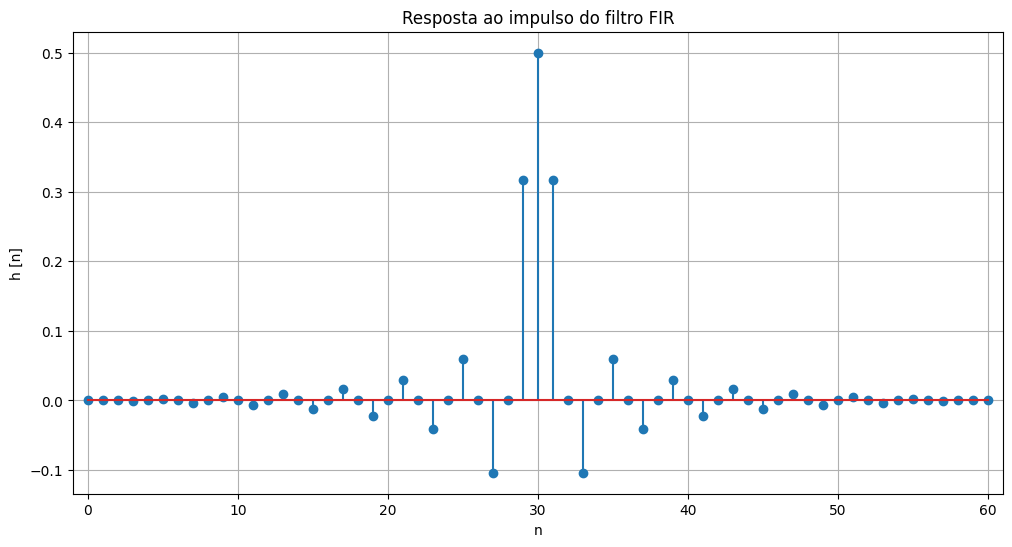

In [58]:
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(fir_direct)), fir_direct)
plt.title('Resposta ao impulso do filtro FIR')
plt.xlabel('n')
plt.ylabel('h [n]')
xlim = [-1, 61]
plt.xlim(xlim)
plt.grid(True)
plt.show()

Como esperado do filtro passa-baixas (tipo I) projetado, a resposta ao impulso do filtro projetado se aproxima de uma função sinc, com comprimento $M + 1$, com simetria par e centrada em $M/2$

In [59]:
omega_direct, response_direct = freqz(fir_direct, worN=10192)       # Calcula resposta do filtro na forma direta
omega_direct_norm = omega_direct / np.pi                            # Normaliza a frequência para o intervalo [0, 1]

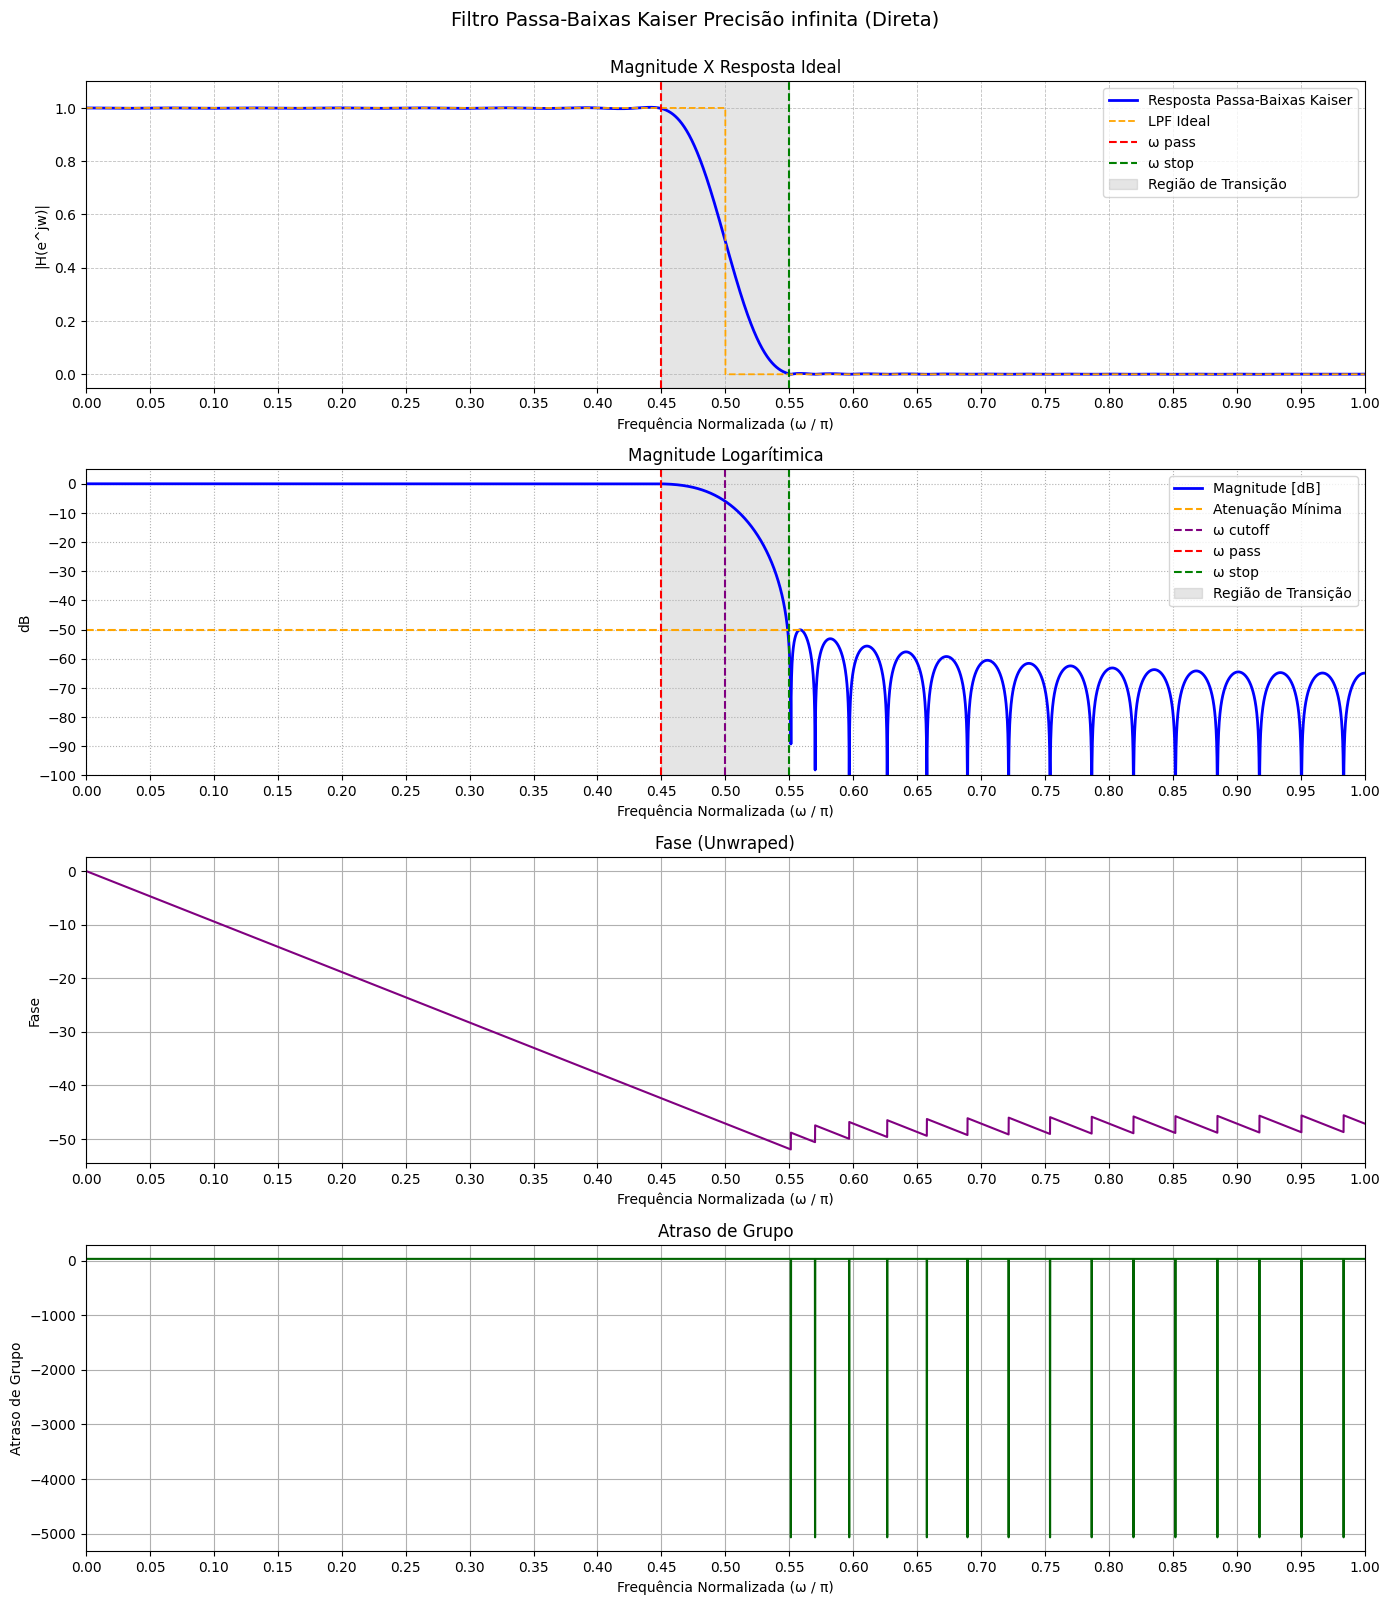

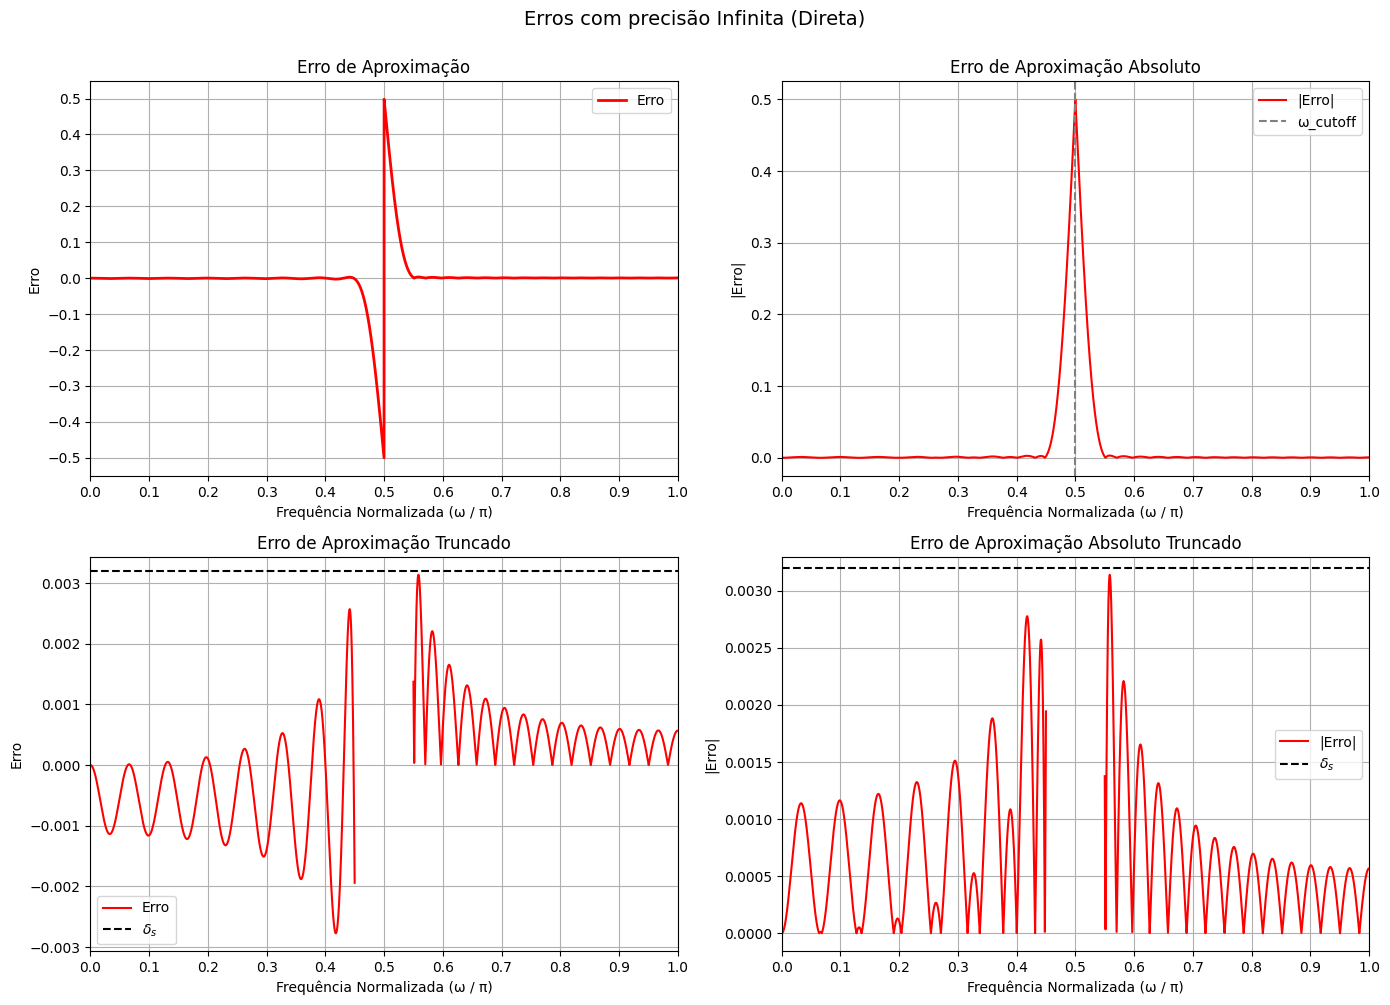

In [60]:
plot_graphs(omega_direct_norm, response_direct, 'Direta', 'infinita',True)
plot_errors(omega_direct_norm, response_direct, 'Direta', 'Infinita')

É possível observar que, ao utilizar o projeto por janela de Kaiser, tanto a banda passante quanto a banda de rejeição apresentam oscilações características. Esse comportamento está relacionado à limitação prática de não ser possível somar uma quantidade infinita de senoides na representação por séries de Fourier. Esse efeito é conhecido como fenômeno de Gibbs e é esperado para projetos de filtros que utilizando o janelamento.

Além disso, os gráficos da fase e do atraso de grupo apresentam o formato esperado para um filtro do tipo 1, onde na banda passante e na região de transição o atraso de grupo é constante, isto é, a fase é linear. Os impulsos na banda de rejeição ocorrem pois, nessa faixa, a magnitude assume valores muito baixos, o que leva problemas numéricos no cálculo da fase e, consequentemente, a variação rápida na fase, causa os impulsos no atraso de grupo.

Para a resposta em frequência (dB), fica evidente que, ao atingir a frequência de corte, o filtro está com uma atenuação de 50 dB. Além disso, também é possível perceber que os outros requisitos como largura da banda passante, da região de transição e outros também está sendo cumprida.

Como esperado, o erro máximo de aproximação não excede o valor de $\delta_s$ previamente especificado, nem para a banda de passagem nem para a banda de rejeição. Observa-se também que o pico do erro ocorre em $\omega_c$, o que era previsto, dado que nesse ponto o filtro ideal do tipo passa-baixas apresenta uma descontinuidade (i.e. ele muda abruptamente de 1 para 0). Já o filtro projetado com a janela de Kaiser gera uma transição contínua, resultando em uma diferença máxima em $\omega_c$.


### Estrutura em Cascata

c:\Users\rodri\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_filter_design.py:1218: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


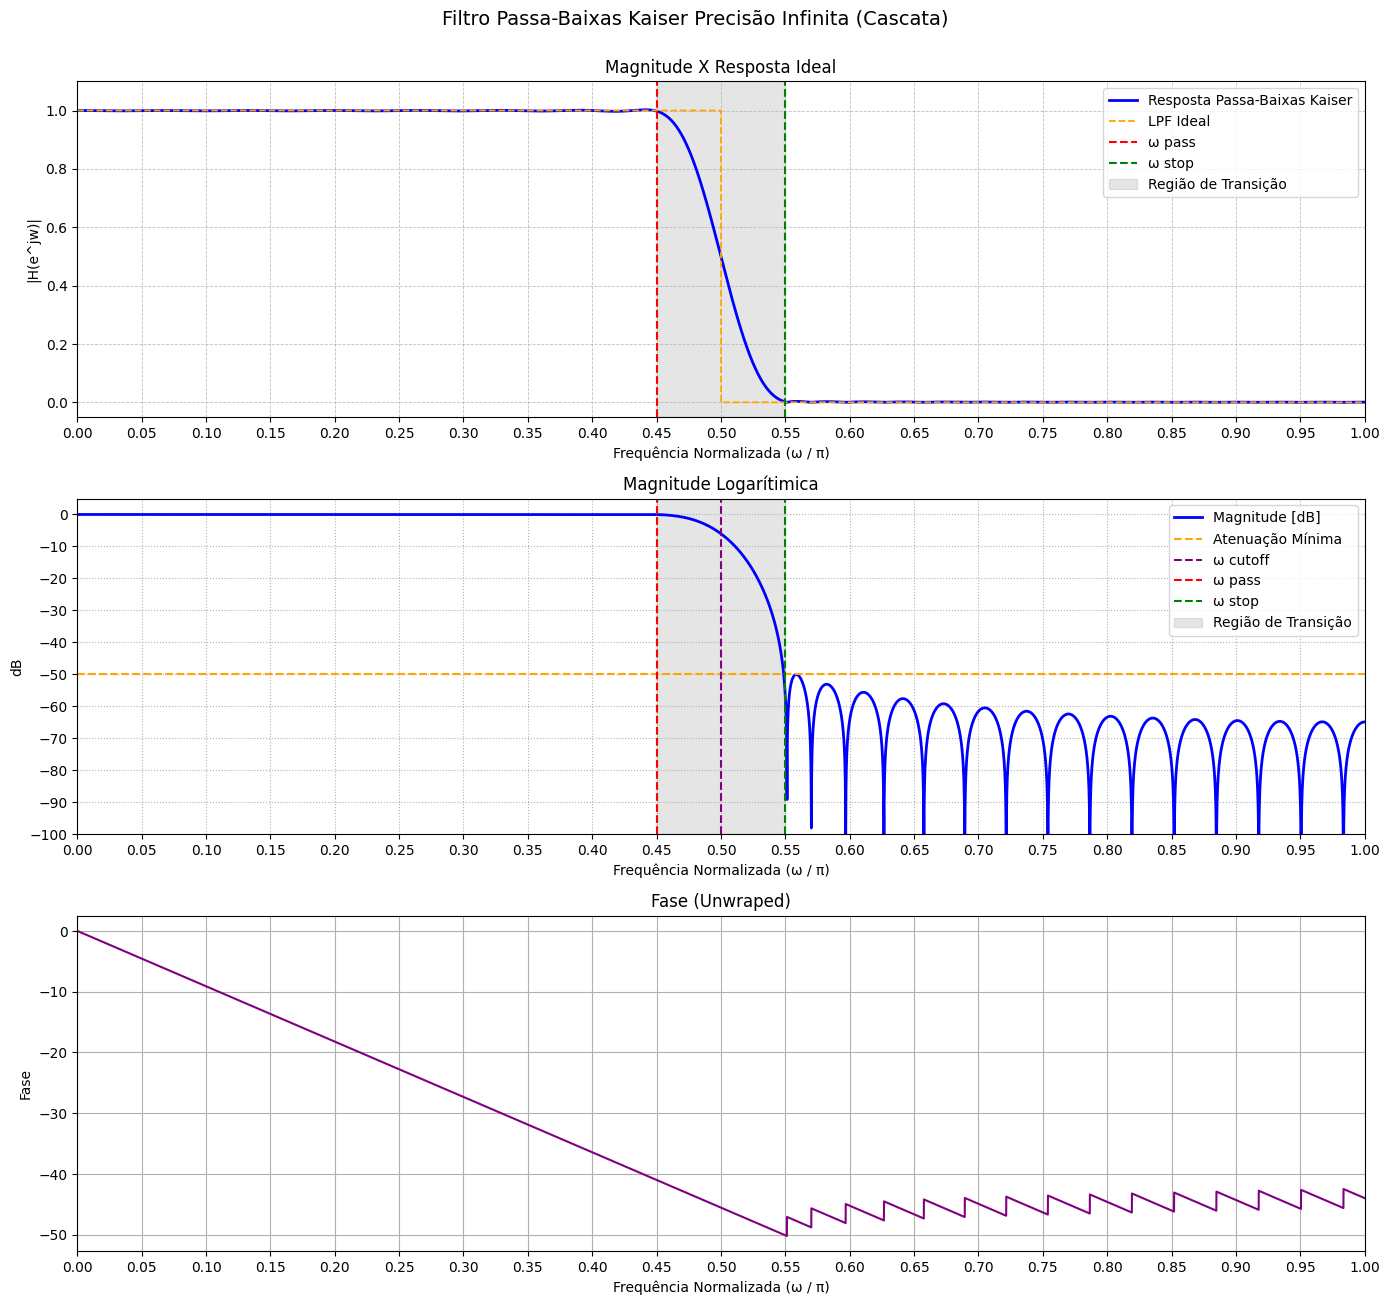

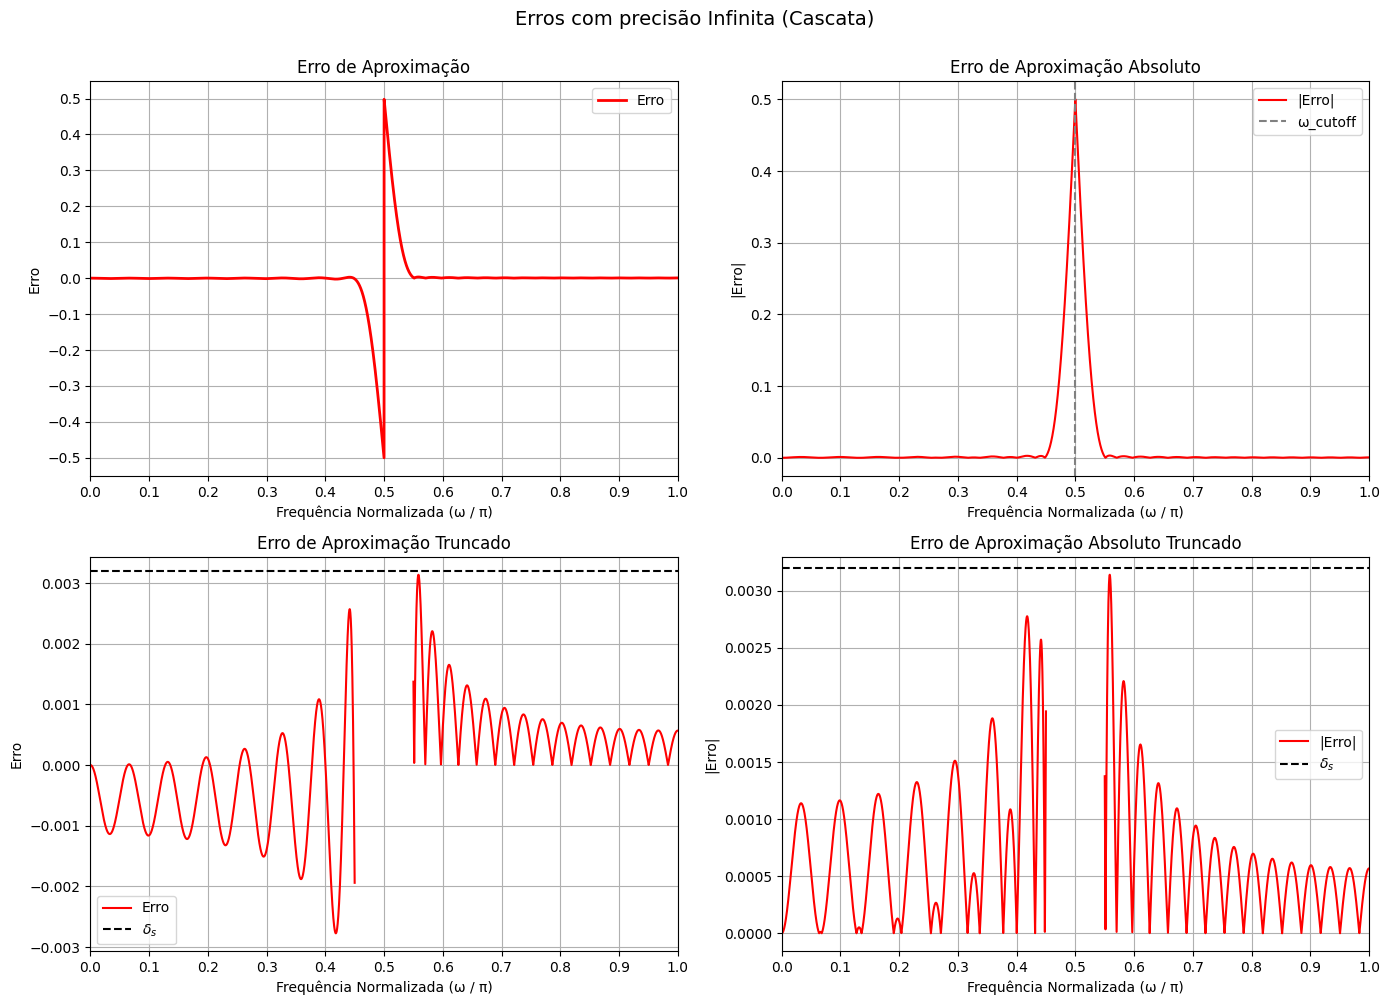

In [61]:
# Constrói o filtro usando a forma em cascata
fir_cascade = tf2sos(fir_direct, [1.0])

omega_cascade, response_cascade = sosfreqz(fir_cascade, worN=10192)   # Calcula resposta do filtro em cascata
omega_cascade_norm = omega_cascade / np.pi                            # Normaliza a frequência para o intervalo [0, 1]
    
plot_graphs(omega_cascade_norm, response_cascade, 'Cascata', 'Infinita')
plot_errors(omega_cascade_norm, response_cascade, 'Cascata', 'Infinita')

Pela análise realizada, observa-se que, sob precisão infinita, a resposta em frequência dos filtros projetados nas formas direta e em cascata apresenta variações insignificantes. Conforme descrito por Oppenheim, Schafer e Buck (2010):

> OPPENHEIM, Alan V.; SCHAFER, Ronald W.; BUCK, John R. *Processamento de sinais em tempo discreto*. 3. ed. São Paulo: Pearson Prentice Hall, 2010.

Esse comportamento é esperado, uma vez que ambas as implementações são teoricamente equivalentes na ausência de limitações numéricas. Neste caso, a precisão de 64 bits em ponto flutuante utilizada pela linguagem de programação é suficiente para que os efeitos da quantização sejam desprezíveis.

Para avaliar os impactos da precisão numérica, os mesmos filtros serão projetados a seguir com restrições na representação dos coeficientes.


## 3. Avaliação do Impacto da Quantização de Parâmetros

In [62]:
precision_list = ['8 casas', '7 casas', '6 casas', '5 casas', '4 casas', '3 casas']

def plot_magnitude_dB_resume(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list):
    fig, axes = plt.subplots(3, 2, figsize=(16, 13))
    axes = axes.flatten()

    for direct_omega_norm, cascade_omega_norm, direct_response, cascade_response, precision, ax in zip(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list, axes):
        direct_response_mag, direct_response_dB, direct_phase, direct_group_delay = calculate_variables(direct_omega_norm, direct_response)
        cascade_response_mag, cascade_response_dB, cascade_phase, cascade_group_delay = calculate_variables(cascade_omega_norm, cascade_response)

        ax.plot(direct_omega_norm, direct_response_dB, linewidth=2, label='Direta')
        ax.plot(cascade_omega_norm, cascade_response_dB, linewidth=2, linestyle='--', label='Cascata')
        ax.set_title(f'Magnitude Logarítimica com {precision} Decimais')
        ax.set_xlabel('Frequência Normalizada (ω / π)')
        ax.set_ylabel('dB')
        ax.set_xticks(np.arange(0, 1.1, 0.1))
        ax.set_yticks(np.arange(-100, 10, 10))
        ax.set_ylim(-100, 5)
        ax.set_xlim(0, 1.0)
        ax.axhline(-50, color='red', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
        ax.grid(True)
        ax.legend()

    plt.suptitle(f'Comparação de Resposta [Estrutura Direta X Cascata] (Precisão Finita)', fontsize=14, y=1.001)
    plt.tight_layout()
    plt.show()

# Plota o conjunto de gráficos de fase com precisão finita
def plot_phase_resume(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list):
    fig, axes = plt.subplots(3, 2, figsize=(16, 13))
    axes = axes.flatten()

    for direct_omega_norm, cascade_omega_norm, direct_response, cascade_response, precision, ax in zip(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list, axes):
        direct_response_mag, direct_response_dB, direct_phase, direct_group_delay = calculate_variables(direct_omega_norm, direct_response)
        cascade_response_mag, cascade_response_dB, cascade_phase, cascade_group_delay = calculate_variables(cascade_omega_norm, cascade_response)

        ax.plot(direct_omega_norm, direct_phase, color='red', label='Direta')
        ax.plot(cascade_omega_norm, cascade_phase, color='purple', linestyle='--', label='Cascata')
        ax.set_title(f'Fase com {precision}')
        ax.set_xlabel('Frequência Normalizada (ω / π)')
        ax.set_ylabel('Fase')
        ax.set_xlim(0, 1.0)
        ax.set_xticks(np.arange(0, 1.05, 0.05))
        ax.grid(True)
        ax.legend()

    plt.suptitle(f'Comparação de Fase [Estrutura Direta X Cascata] (Precisão Finita)', fontsize=14, y=1.001)
    plt.tight_layout()
    plt.show()

# Plota o conjunto de gráficos de erro truncado com precisão finita
def plot_error_resume(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list):
    fig, axes = plt.subplots(3, 2, figsize=(16, 13))
    axes = axes.flatten()

    for i, (direct_omega_norm, cascade_omega_norm, direct_response, cascade_response, precision, ax) in enumerate(zip(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list, axes)):
        direct_response_mag, direct_response_dB, direct_phase, direct_group_delay = calculate_variables(direct_omega_norm, direct_response)
        cascade_response_mag, cascade_response_dB, cascade_phase, cascade_group_delay = calculate_variables(cascade_omega_norm, cascade_response)
        
        # Direct
        lpf_ideal_direct = np.where(direct_omega_norm <= w_cutoff / np.pi, 1.0, 0.0)
        error_direct = direct_response_mag - lpf_ideal_direct
        truncate_pass_direct = direct_omega_norm <= w_pass / np.pi
        truncate_stop_direct = direct_omega_norm >= w_stop / np.pi
        ax.plot(direct_omega_norm[truncate_pass_direct], error_direct[truncate_pass_direct], color='red', linewidth=1.5, label='Direta')
        ax.plot(direct_omega_norm[truncate_stop_direct], error_direct[truncate_stop_direct], color='red', linewidth=1.5)

        if i <= 3:
            # Cascade
            lpf_ideal_cascade = np.where(cascade_omega_norm <= w_cutoff / np.pi, 1.0, 0.0)
            error_cascade = cascade_response_mag - lpf_ideal_cascade
            truncate_pass_cascade = cascade_omega_norm <= w_pass / np.pi
            truncate_stop_cascade = cascade_omega_norm >= w_stop / np.pi
            ax.plot(cascade_omega_norm[truncate_pass_cascade], error_cascade[truncate_pass_cascade], color='darkblue', linewidth=1.5, label='Cascata')
            ax.plot(cascade_omega_norm[truncate_stop_cascade], error_cascade[truncate_stop_cascade], color='darkblue', linewidth=1.5)


        ax.axhline(0.0032, color='black', linestyle='--', linewidth=1.5, label='$\\delta_s$')
        ax.axhline(-0.0032, color='black', linestyle='--', linewidth=1.5)
        ax.set_title(f'Erro de Aproximação Truncado com {precision}')
        ax.set_xlabel('Frequência Normalizada (ω / π)')
        ax.set_ylabel('Erro')
        ax.set_xlim(0, 1.0)
        ax.set_xticks(np.arange(0, 1.1, 0.1))
        ax.grid(True)
        ax.legend()

    plt.suptitle(f'Comparação de Erro Aproximado [Estrutura Direta X Cascata] (Precisão Finita)', fontsize=14, y=1.001)
    plt.tight_layout()
    plt.show()
    
def comparison_graphs(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list):
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    for direct_omega_norm, cascade_omega_norm, direct_response, cascade_response, precision in zip(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list):
        direct_response_mag, direct_response_dB, direct_phase, direct_group_delay = calculate_variables(direct_omega_norm, direct_response)
        cascade_response_mag, cascade_response_dB, cascade_phase, cascade_group_delay = calculate_variables(cascade_omega_norm, cascade_response)

        axes[0].plot(direct_omega_norm, direct_response_dB, label=f'Direta ({precision})')
        axes[0].set_title('Magnitude Logarítimica - Direta')
        axes[0].set_xlabel('Frequência Normalizada (ω / π)')
        axes[0].set_ylabel('Magnitude (dB)')
        axes[0].axhline(-50, color='orange', linestyle='--', linewidth=1.5)
        axes[0].axvline(0.55, color='green', linestyle='--', linewidth=1.5)
        axes[0].grid(True)
        axes[0].set_xlim(0, 1)
        axes[0].set_ylim(-100, 1)
        axes[0].set_xticks(np.arange(0, 1.1, 0.1))
        axes[0].legend(loc='lower left')

        axes[1].plot(cascade_omega_norm, cascade_response_dB, label=f'Cascata ({precision})')
        axes[1].set_title('Magnitude Logarítimica - Cascata')
        axes[1].set_xlabel('Frequência Normalizada (ω / π)')
        axes[1].set_ylabel('Magnitude (dB)')
        axes[1].axhline(-50, color='orange', linestyle='--', linewidth=1.5)
        axes[1].axvline(0.55, color='green', linestyle='--', linewidth=1.5)
        axes[1].grid(True)
        axes[1].set_xlim(0, 1)
        axes[1].set_ylim(-100, 1)
        axes[1].set_xticks(np.arange(0, 1.1, 0.1))
        axes[1].legend()

    plt.suptitle('Variação Direta X Cascata', fontsize=14, y=1.001)
    plt.tight_layout()
    plt.show()


### Aproximação Estrutura Direta

In [63]:
# ============================== 8 Casas Decimais ==================================== 
fir_direct_8dec = np.round(fir_direct, 8) # Aproxima os coeficientes do filtro

omega_direct_8dec, response_direct_8dec = freqz(fir_direct_8dec, worN=10192) 
omega_direct_norm_8dec = omega_direct_8dec / np.pi

# ============================== 7 Casas Decimais ==================================== 

fir_direct_7dec = np.round(fir_direct, 7)

omega_direct_7dec, response_direct_7dec = freqz(fir_direct_7dec, worN=10192)
omega_direct_norm_7dec = omega_direct_7dec / np.pi  
    
# ============================== 6 Casas Decimais ====================================

fir_direct_6dec = np.round(fir_direct, 6)

omega_direct_6dec, response_direct_6dec = freqz(fir_direct_6dec, worN=10192)
omega_direct_norm_6dec = omega_direct_6dec / np.pi   

# ============================== 5 Casas Decimais ====================================

fir_direct_5dec = np.round(fir_direct, 5)

omega_direct_5dec, response_direct_5dec = freqz(fir_direct_5dec, worN=10192) 
omega_direct_norm_5dec = omega_direct_5dec / np.pi

# ============================== 4 Casas Decimais ====================================

fir_direct_4dec = np.round(fir_direct, 4)

omega_direct_4dec, response_direct_4dec = freqz(fir_direct_4dec, worN=10192) 
omega_direct_norm_4dec = omega_direct_4dec / np.pi

# ============================== 3 Casas Decimais ====================================
fir_direct_3dec = np.round(fir_direct, 3)

omega_direct_3dec, response_direct_3dec = freqz(fir_direct_3dec, worN=10192) 
omega_direct_norm_3dec = omega_direct_3dec / np.pi                   

direct_responses_list = [response_direct_8dec, response_direct_7dec, response_direct_6dec, response_direct_5dec, response_direct_4dec, response_direct_3dec]
direct_omegas_norm_list = [omega_direct_norm_8dec, omega_direct_norm_7dec, omega_direct_norm_6dec, omega_direct_norm_5dec, omega_direct_norm_4dec, omega_direct_norm_3dec]

### Aproximação Estrutura em Cascata

In [64]:
# ============================== 8 Casas Decimais ====================================
fir_cascade_8dec = np.round(fir_cascade, 8) # Aproxima o filtro em cascata

omega_cascade_8dec, response_cascade_8dec = sosfreqz(fir_cascade_8dec, worN=10192)
omega_cascade_norm_8dec = omega_cascade_8dec / np.pi

# ============================== 7 Casas Decimais ====================================

fir_cascade_7dec = np.round(fir_cascade, 7)

omega_cascade_7dec, response_cascade_7dec = sosfreqz(fir_cascade_7dec, worN=10192)
omega_cascade_norm_7dec = omega_cascade_7dec / np.pi

# ============================== 6 Casas Decimais ====================================

fir_cascade_6dec = np.round(fir_cascade, 6)

omega_cascade_6dec, response_cascade_6dec = sosfreqz(fir_cascade_6dec, worN=10192)
omega_cascade_norm_6dec = omega_cascade_6dec / np.pi

# ============================== 5 Casas Decimais ====================================

fir_cascade_5dec = np.round(fir_cascade, 5)

omega_cascade_5dec, response_cascade_5dec = sosfreqz(fir_cascade_5dec, worN=10192)
omega_cascade_norm_5dec = omega_cascade_5dec / np.pi

# ============================== 4 Casas Decimais ====================================

fir_cascade_4dec = np.round(fir_cascade, 4)

omega_cascade_4dec, response_cascade_4dec = sosfreqz(fir_cascade_4dec, worN=10192)
omega_cascade_norm_4dec = omega_cascade_4dec / np.pi

# ============================== 3 Casas Decimais ====================================

fir_cascade_3dec = np.round(fir_cascade, 3)

omega_cascade_3dec, response_cascade_3dec = sosfreqz(fir_cascade_3dec, worN=10192)
omega_cascade_norm_3dec = omega_cascade_3dec / np.pi

cascade_responses_list = [response_cascade_8dec, response_cascade_7dec, response_cascade_6dec, response_cascade_5dec, response_cascade_4dec, response_cascade_3dec]
cascade_omegas_norm_list = [omega_cascade_norm_8dec, omega_cascade_norm_7dec, omega_cascade_norm_6dec, omega_cascade_norm_5dec, omega_cascade_norm_4dec, omega_cascade_norm_3dec]

### Comparação 

C:\Users\rodri\AppData\Local\Temp\ipykernel_14296\463262122.py:7: RuntimeWarning: divide by zero encountered in log10
  response_dB = 20 * np.log10(abs(response_X_Y))             # Resposta em dB


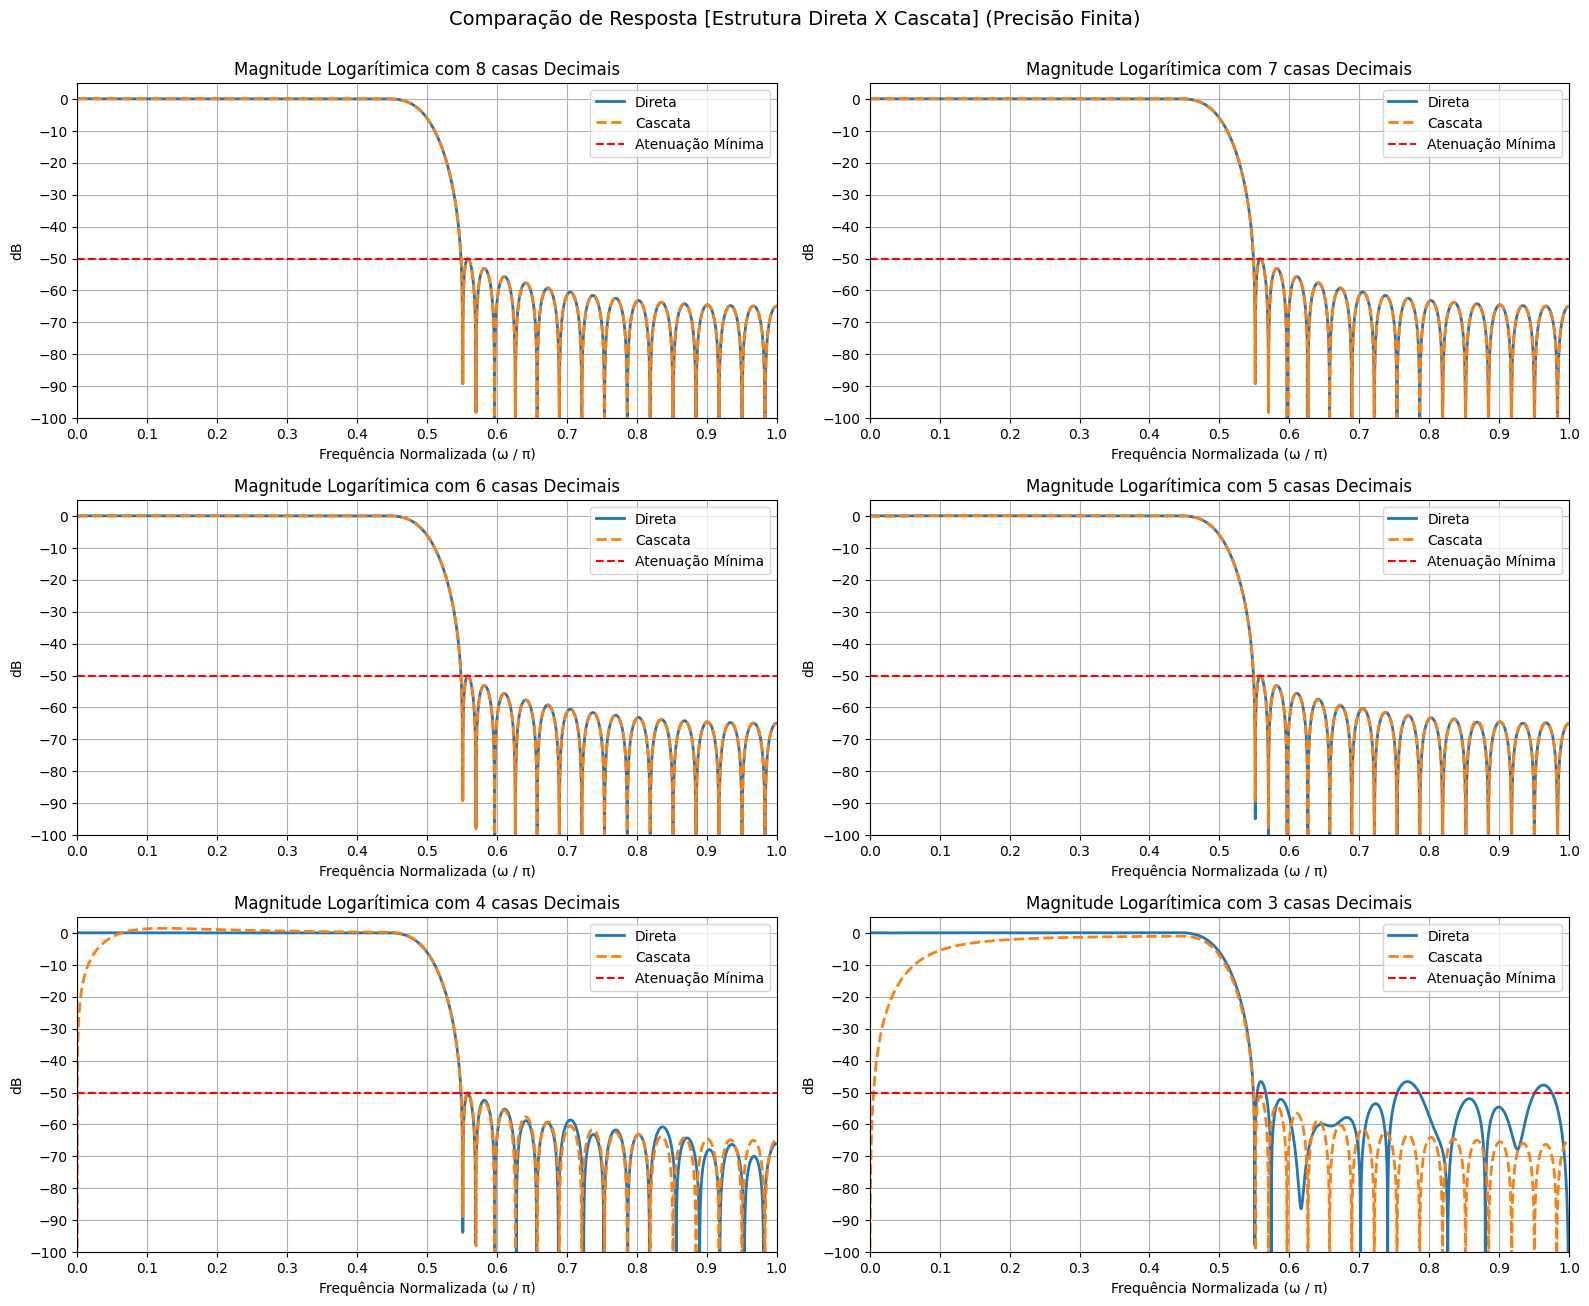

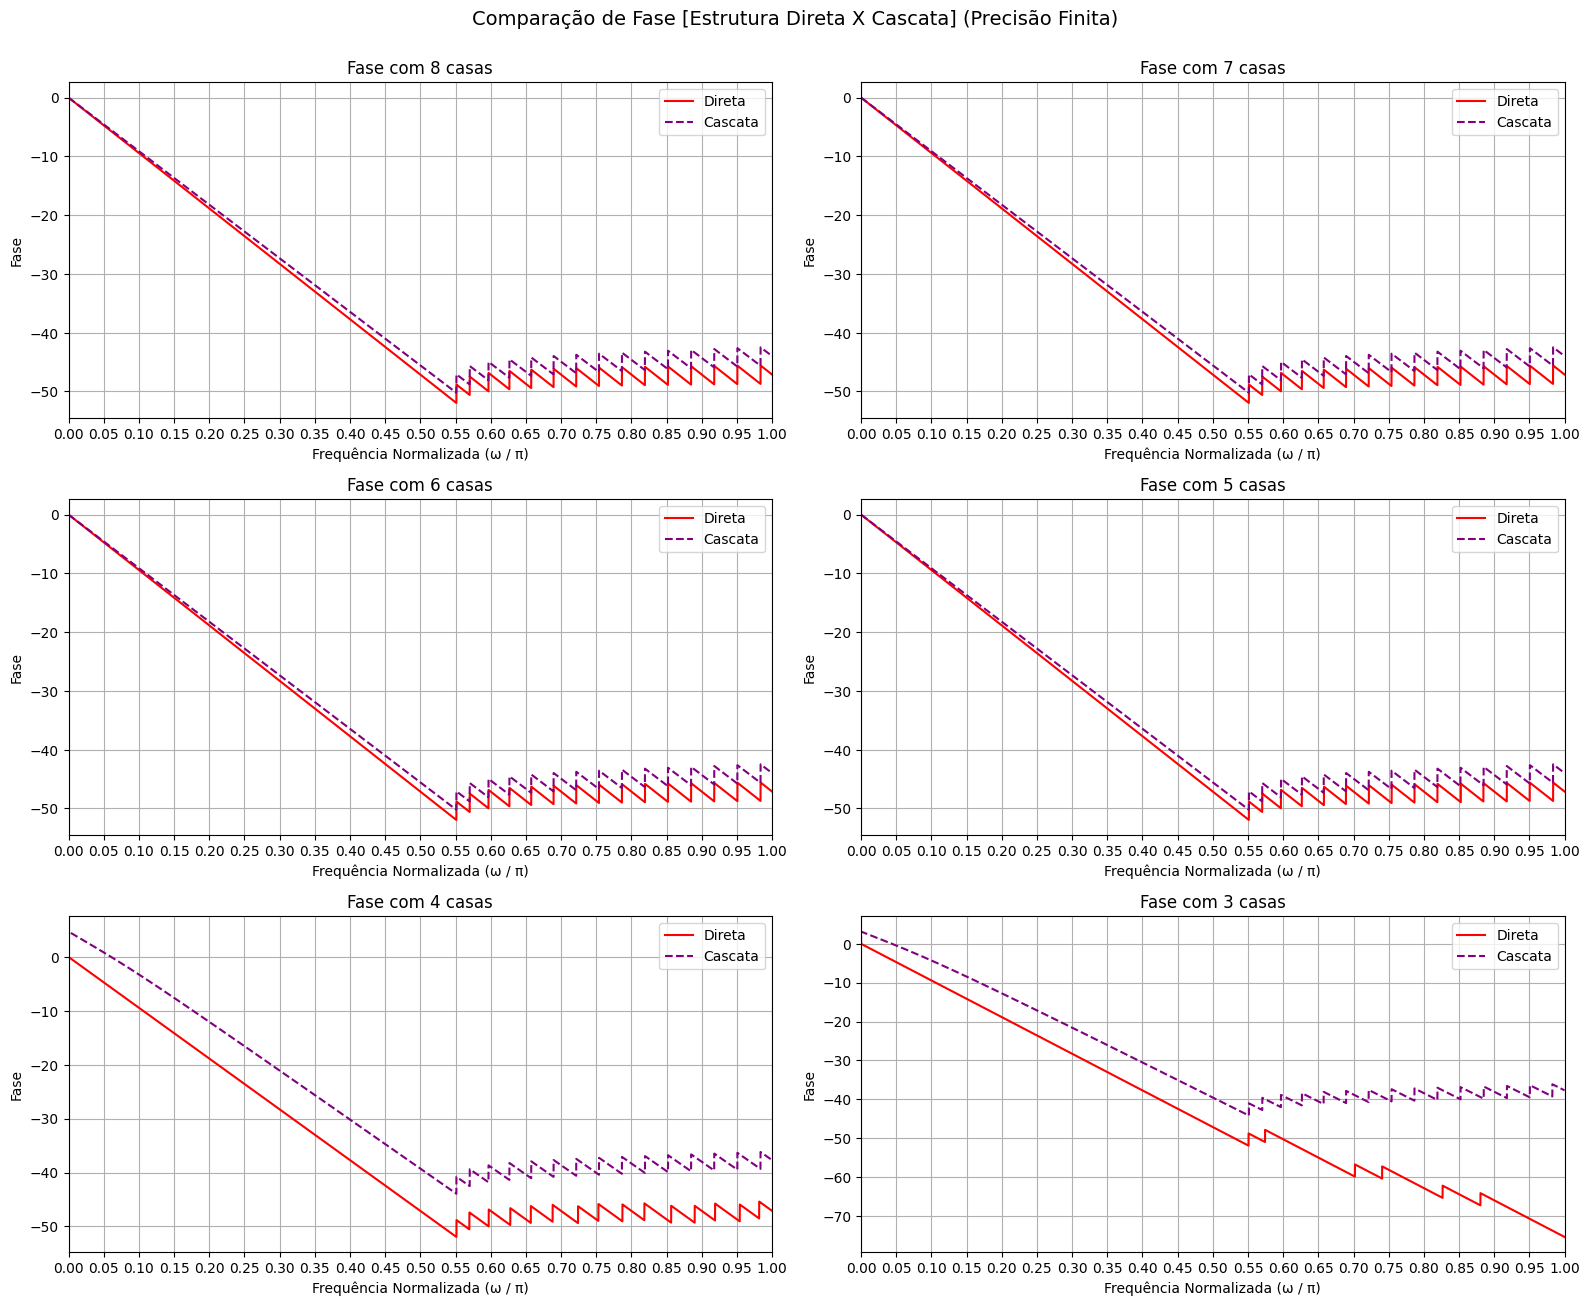

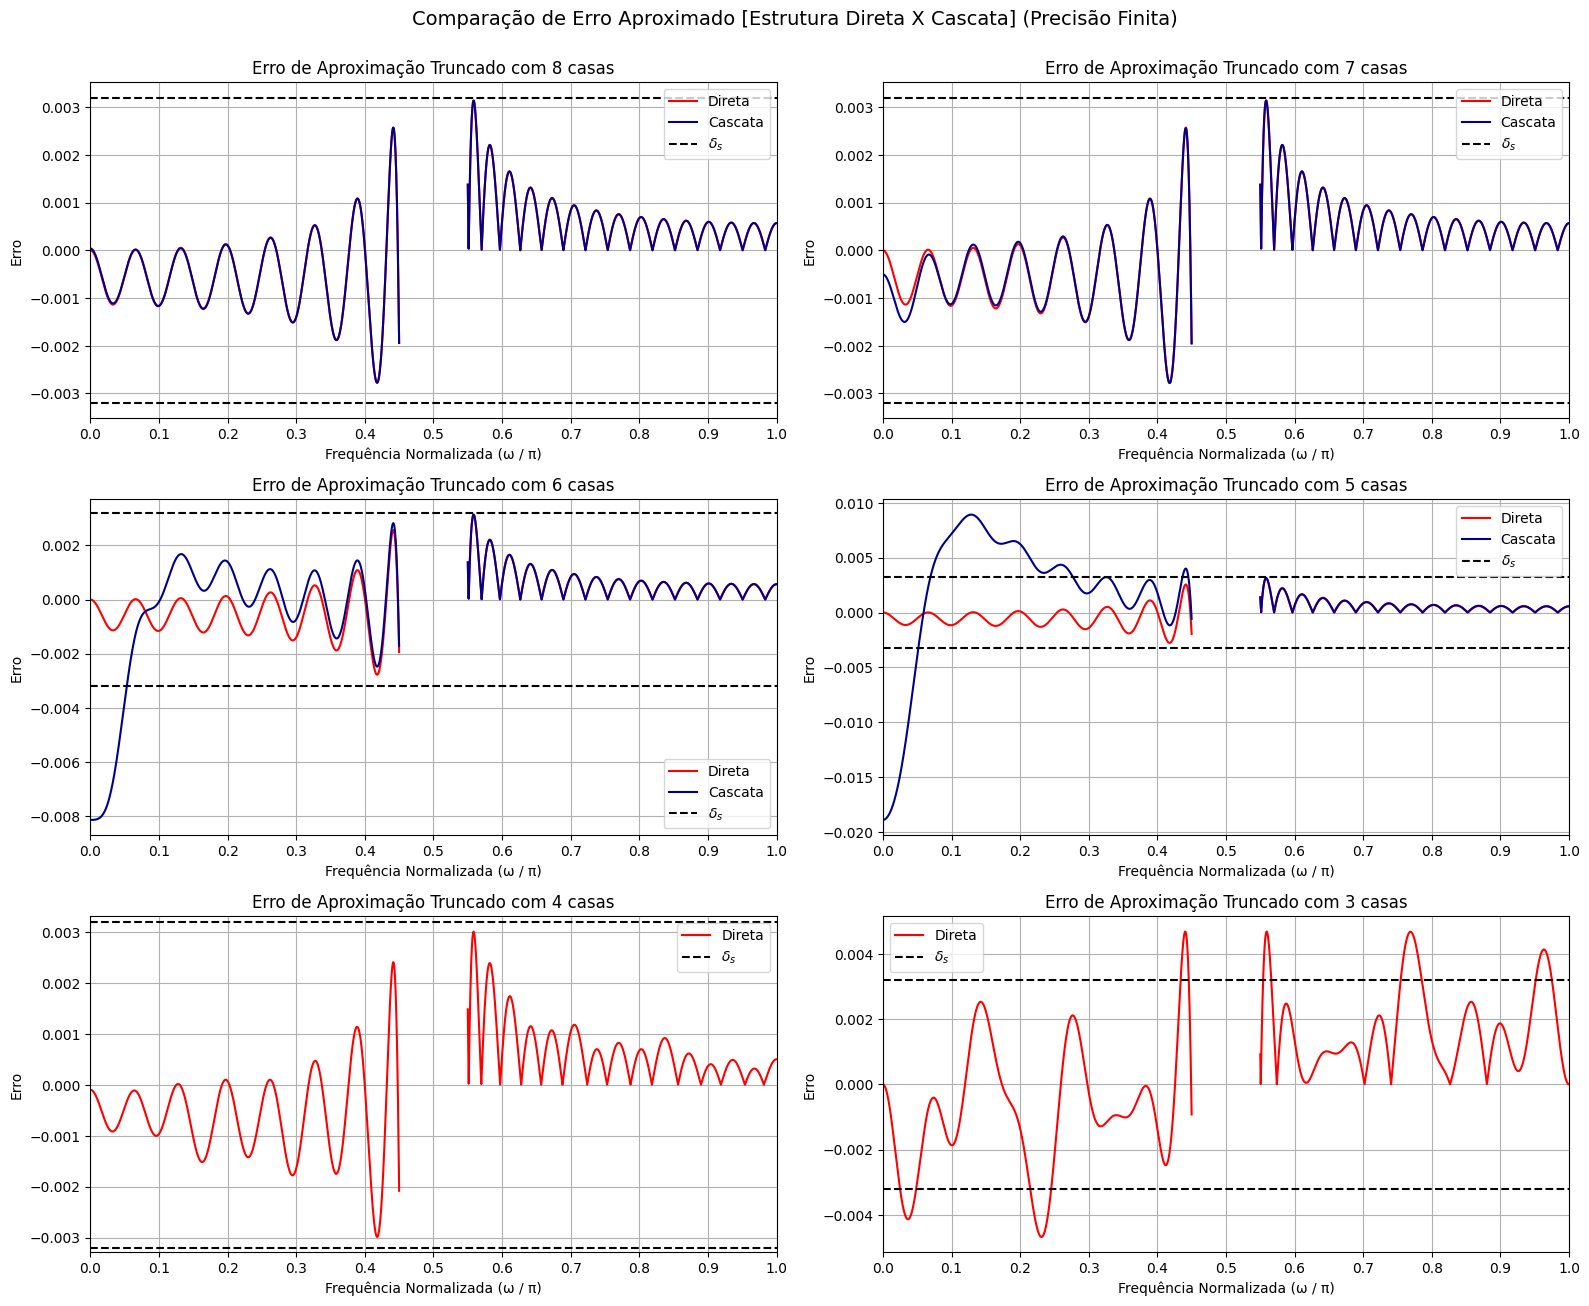

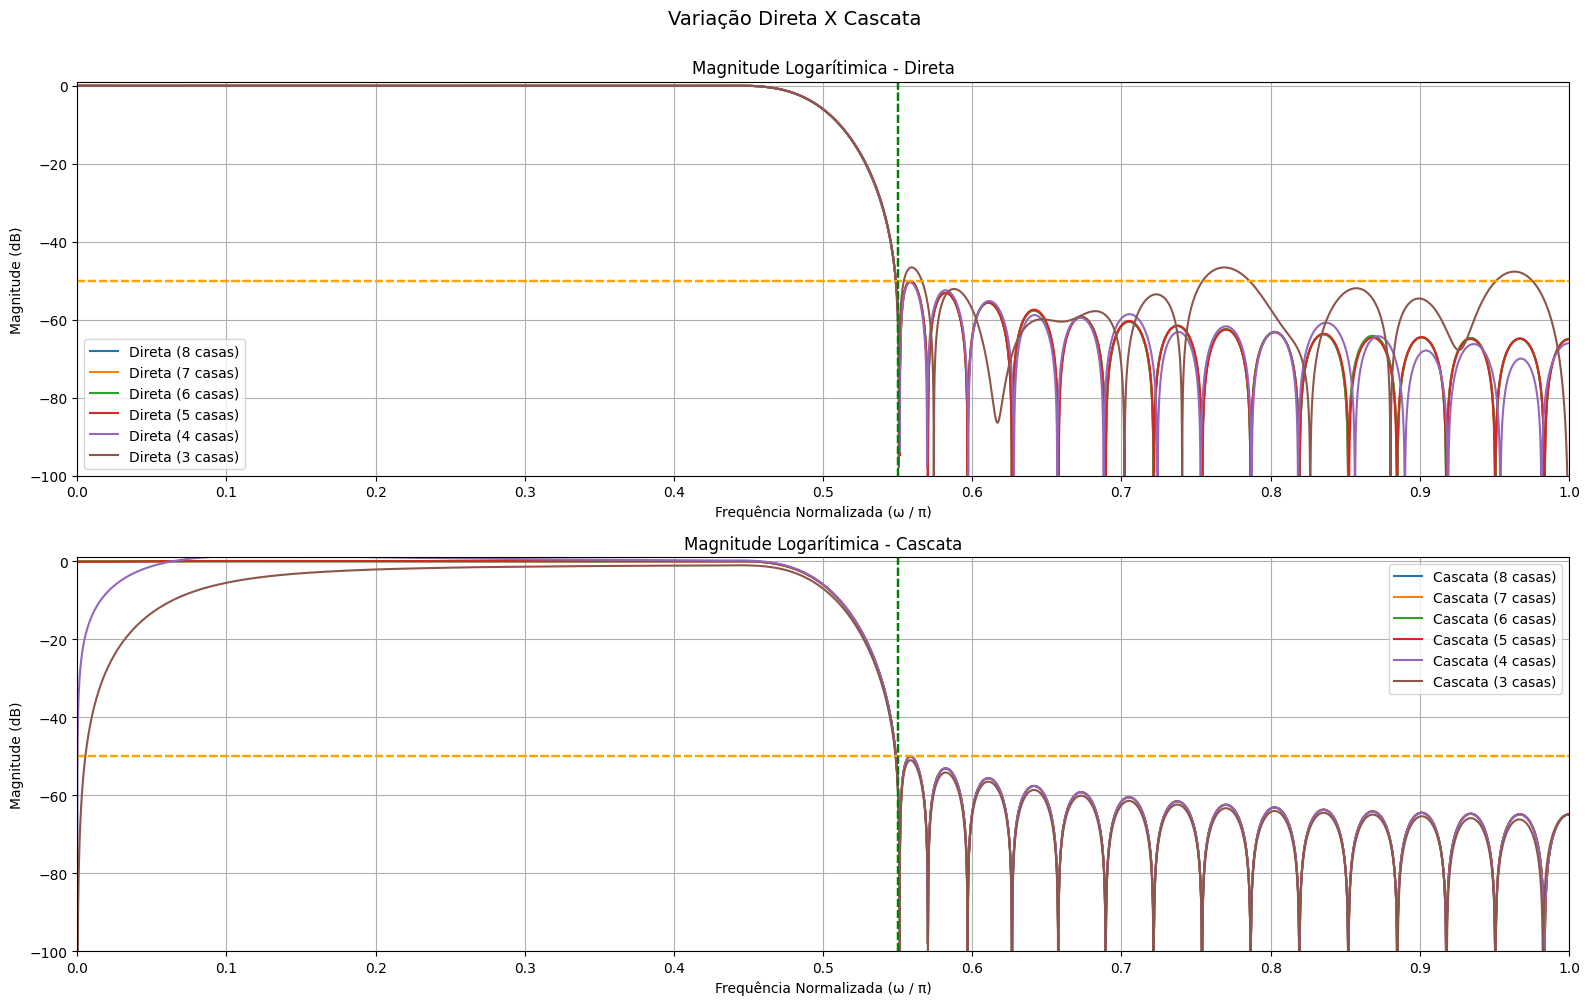

In [65]:
plot_magnitude_dB_resume(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list)
plot_phase_resume(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list)
plot_error_resume(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list)
comparison_graphs(direct_omegas_norm_list, cascade_omegas_norm_list, direct_responses_list, cascade_responses_list, precision_list)


Através dos gráficos de magnitude e dos gráficos de erro, fica evidente que, conforme o número de casas decimais vai diminuindo, a resposta do filtro implementado na forma direta se deforma bem mais do que na forma em cascata. Por exemplo, para o caso em que utiliza-se 8 casas decimais, não é possível visualizar um erro de aproximação significativo e, conforme o número vai diminuindo, os gráficos de erro ficam cade vez menos sobreposto. Ainda, no gráfico de erro aproximado para 3 casas decimais é possível visualizar que o erro da estrutura direta ultrapassou, de forma considerável, o limite definido. Esse resultado era esperado, já que na estrutura direta os erros de quantização dos coeficientes se propagam, afetando mais fortemente a estabilidade e a precisão da resposta em frequência. Já na estrutura em cascata, esse erro é distribuído ao longo de estágios menores , o que limita a propagação do erro e torna o sistema mais robusto à quantização.

O gráfico de comparação evidencia a diferença na variação das duas estruturas.

Além disso, como foi comentado anteriormente, magnitudes muito próximas de zero costumam causar descontinuidades na fase devido à limitações numéricas. Com isso, é plausível admitir que o filtro cuja fase apresenta mais descontinuidades na faixa de rejeição está, atenuando menos o sinal nessa região. Essa hipótese é reforçada pela análise dos gráficos, que mostram que, quanto maior o erro aproximado, mais suave é a fase.

Ademais, não foi possível plotar nem a magnitude e nem o erro do filtro em cascata para precisão de 4 e 3 casas decimais devido à erros numéricos, uma vez que números muito pequenos são aproximados para 0. Por isso, a análise utilizou a aproximação com 3 casas decimais como o limite inferior. Ainda assim, os gráficos do erro para a estrutura em cascata de 6 e 5 casas decimais, os gráficos de erro apresentam distorções significativas, indicando que os resultados apresentados podem não ser confiáveis. Os gráficos de magnitude para a estrutura em cascata também são afetados pelos erros numéricos. Por isso, alguns deles não começam de 0 dB.

## 4. Transformação em Frequência

Para projetar filtros constantes por partes, primeiramente projeta-se o passa-baixas e, então, realizam-se transformações em frequência para obter os outros filtros. Isso será demonstrado a seguir, de forma que, ao aplicar as transformações, espera-se conseguir outros tipos de filtros conhecidos, como passa-altas, passa-faixas e outros.

In [66]:
def plot_transformations_graph(omega_X_norm_Y, response_X_Y, titulo:str, passa_faixa: bool = False, rejeita_faixa: bool = False):
    
    response_mag, response_dB, phase, group_delay = calculate_variables(omega_X_norm_Y, response_X_Y)
  
    fig, axes = plt.subplots(3, 1, figsize=(14, 13))

    
    # Gráfico 1: |H(e^jw)|
    axes[0].plot(omega_X_norm_Y, response_mag, label='Resposta', color='blue', linewidth=2)
    axes[0].set_title('Magnitude X Resposta Ideal')
    axes[0].set_xlabel('Frequência Normalizada (ω / π)')
    axes[0].set_ylabel('|H(e^jw)|')
    axes[0].set_xticks(np.arange(0, 1.05, 0.05))
    axes[0].set_xlim(0, 1.0)
    axes[0].set_ylim(-0.05, 1.1)
    if rejeita_faixa:
        # Passagem
        axes[0].axvline(0.45/2, color='green', linestyle='--', linewidth=1.5, label='ω pass')
        axes[0].axvline(1 - 0.45/2, color='green', linestyle='--', linewidth=1.5)
        axes[0].axvspan(0, 0.45/2, color='green', alpha=0.1, label='Banda de Passagem')
        axes[0].axvspan(1 - 0.45/2, 1, color='green', alpha=0.1)
        
        # Rejeição
        axes[0].axvline(0.45/2 + 0.1/2, color='red', linestyle='--', linewidth=1.5, label='ω stop')
        axes[0].axvline(1 - 0.45/2 - 0.1/2, color='red', linestyle='--', linewidth=1.5)
        axes[0].axvspan(0.45/2 + 0.1/2, 1 - 0.45/2 - 0.1/2, color='red', alpha=0.1, label='Banda de Rejeição')
        
    elif passa_faixa:
        # Rejeição
        axes[0].axvline(0.45/2, color='red', linestyle='--', linewidth=1.5, label='ω pass')
        axes[0].axvline(1 - 0.45/2, color='red', linestyle='--', linewidth=1.5)
        axes[0].axvspan(0, 0.45/2, color='red', alpha=0.1, label='Banda de Rejeição')
        axes[0].axvspan(1 - 0.45/2, 1, color='red', alpha=0.1)
        
        # Passagem
        axes[0].axvline(0.45/2 + 0.1/2, color='green', linestyle='--', linewidth=1.5, label='ω stop')
        axes[0].axvline(1 - 0.45/2 - 0.1/2, color='green', linestyle='--', linewidth=1.5)
        axes[0].axvspan(0.45/2 + 0.1/2, 1 - 0.45/2 - 0.1/2, color='green', alpha=0.1, label='Banda de Passagem')
    else:
        axes[0].axvspan(0.45, 0.55, color='gray', alpha=0.1, label='Região de Transição')
        axes[0].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω stop')
        axes[0].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω pass')
        
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
    axes[0].legend()

    # Gráfico 2: Ganho em dB
    axes[1].plot(omega_X_norm_Y, response_dB, color='blue', linewidth=2, label='Magnitude [dB]')
    axes[1].set_title('Magnitude Logarítimica')
    axes[1].set_xlabel('Frequência Normalizada (ω / π)')
    axes[1].set_ylabel('dB')
    axes[1].set_xticks(np.arange(0, 1.05, 0.05))
    axes[1].set_yticks(np.arange(-100, 10, 10))
    axes[1].set_ylim(-100, 5)
    axes[1].set_xlim(0, 1.0)
    
    if rejeita_faixa:
        # Passagem
        axes[1].axvline(0.45/2, color='green', linestyle='--', linewidth=1.5, label='ω pass')
        axes[1].axvline(1 - 0.45/2, color='green', linestyle='--', linewidth=1.5)
        axes[1].axvspan(0, 0.45/2, color='green', alpha=0.1, label='Banda de Passagem')
        axes[1].axvspan(1 - 0.45/2, 1, color='green', alpha=0.1)
        
        # Rejeição
        axes[1].axvspan(0.45/2 + 0.1/2, 1 - 0.45/2 - 0.1/2, color='red', alpha=0.1, label='Banda de Rejeição')
        axes[1].axvline(0.45/2 + 0.1/2, color='red', linestyle='--', linewidth=1.5, label='ω stop')
        axes[1].axvline(1 - 0.45/2 - 0.1/2, color='red', linestyle='--', linewidth=1.5)
    elif passa_faixa:
        # Rejeição
        axes[1].axvline(0.45/2, color='red', linestyle='--', linewidth=1.5, label='ω stop')
        axes[1].axvline(1 - 0.45/2, color='red', linestyle='--', linewidth=1.5)
        axes[1].axvspan(0, 0.45/2, color='red', alpha=0.1, label='Banda de Rejeição')
        axes[1].axvspan(1 - 0.45/2, 1, color='red', alpha=0.1)
        
        # Passagem
        axes[1].axvline(0.45/2 + 0.1/2, color='green', linestyle='--', linewidth=1.5, label='ω pass')
        axes[1].axvline(1 - 0.45/2 - 0.1/2, color='green', linestyle='--', linewidth=1.5)
        axes[1].axvspan(0.45/2 + 0.1/2, 1 - 0.45/2 - 0.1/2, color='green', alpha=0.1, label='Banda de Passagem')
    else:
        axes[1].axvspan(0.45, 0.55, color='gray', alpha=0.1, label='Região de Transição')
        axes[1].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω stop')
        axes[1].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω pass')
        
    axes[1].grid(True, which='both', linestyle=':', linewidth=0.8)
    axes[1].legend()

    # Gráfico 3: Fase
    axes[2].plot(omega_X_norm_Y, phase, color='purple')
    axes[2].set_title('Fase (Unwraped)')
    axes[2].set_xlabel('Frequência Normalizada (ω / π)')
    axes[2].set_ylabel('Fase')
    axes[2].set_xlim(0, 1.0)
    axes[2].set_xticks(np.arange(0, 1.05, 0.05))
    axes[2].grid(True)

    plt.suptitle(titulo, fontsize=14, y=1.0001)
    plt.tight_layout() 
    plt.show()

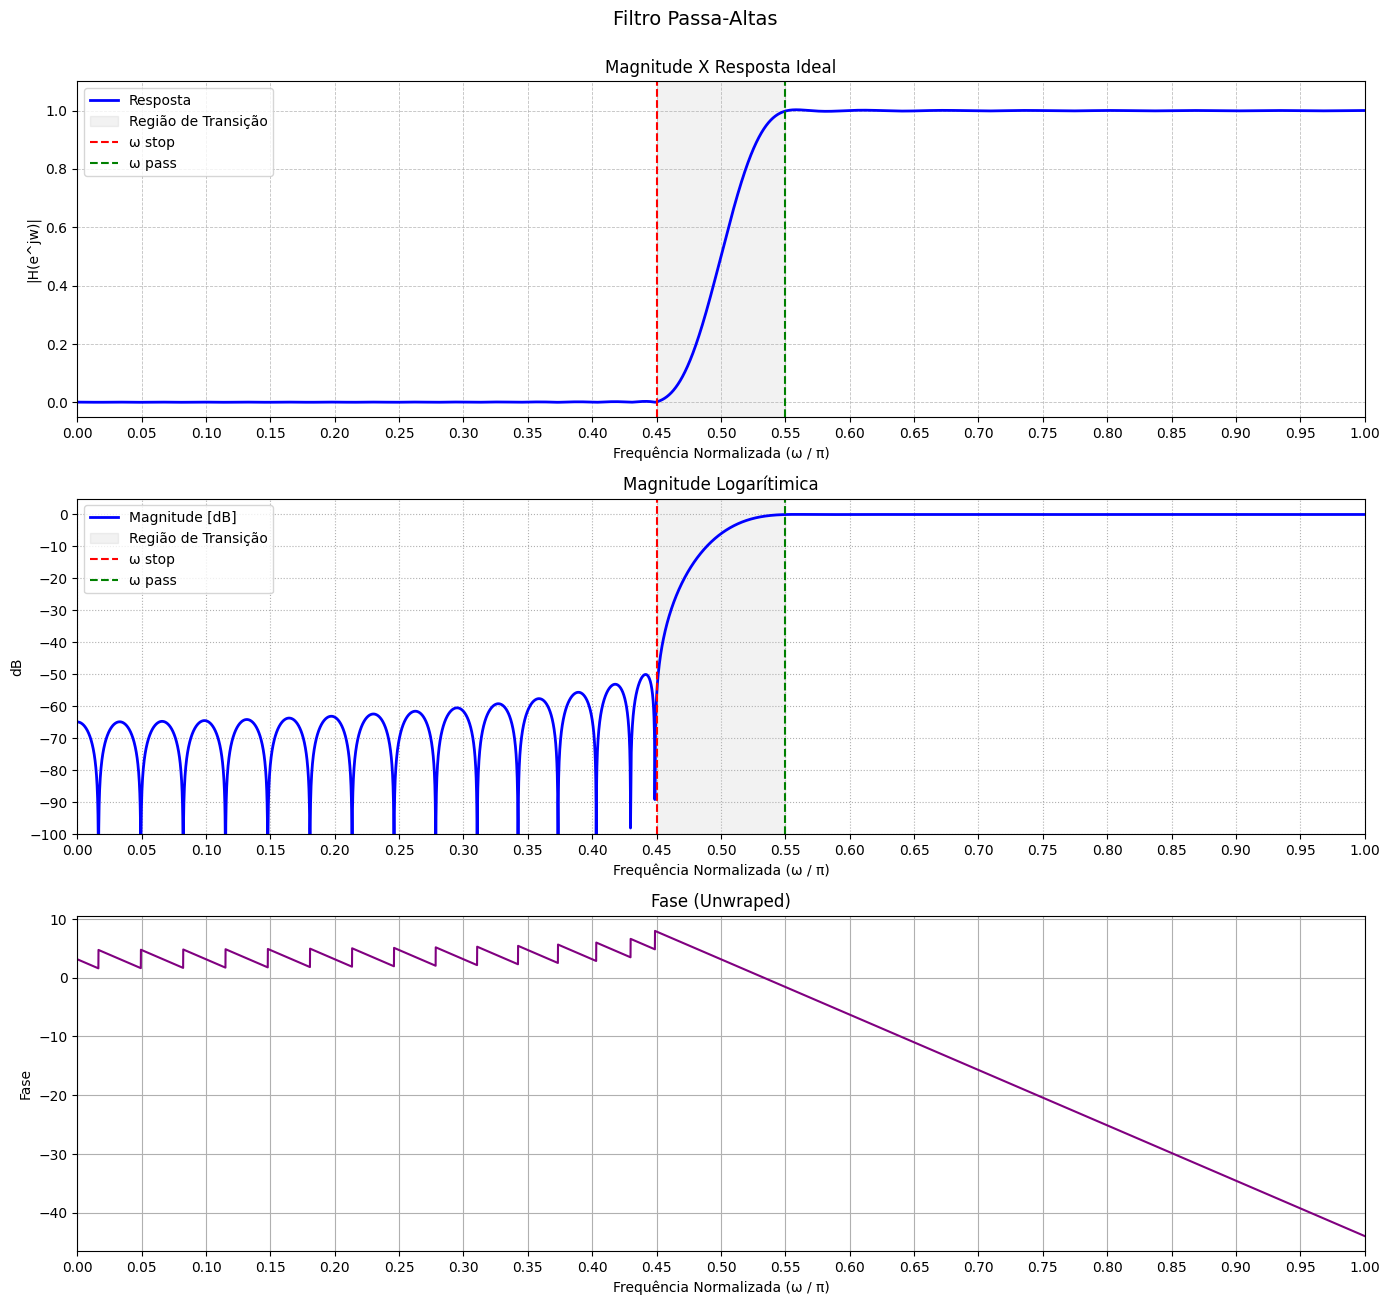

In [67]:
fir_direct_transform1 = fir_direct.copy()
fir_direct_transform1[1::2] *= -1  # Inverte os coeficientes ímpares

omega_transform1, response_transform1 = freqz(fir_direct_transform1, worN=10192)  
omega_transform1_norm = omega_transform1 / np.pi                                   

plot_transformations_graph(omega_transform1_norm, response_transform1, 'Filtro Passa-Altas')

A transformação $Z^{-1} = -z^{-1}$ faz com que os coeficientes de ordem ímpar do filtro tenham seus sinais invertidos. Isso faz com que o filtro Passa-Baixas seja transformados em um filtro Passa-Altas (Desloca a resposta em $\pi$). Esse efeito é perceptível nos gráficos, onde a banda de passagem do filtro original se torna a banda de rejeição no filtro transformado, e vice-versa.

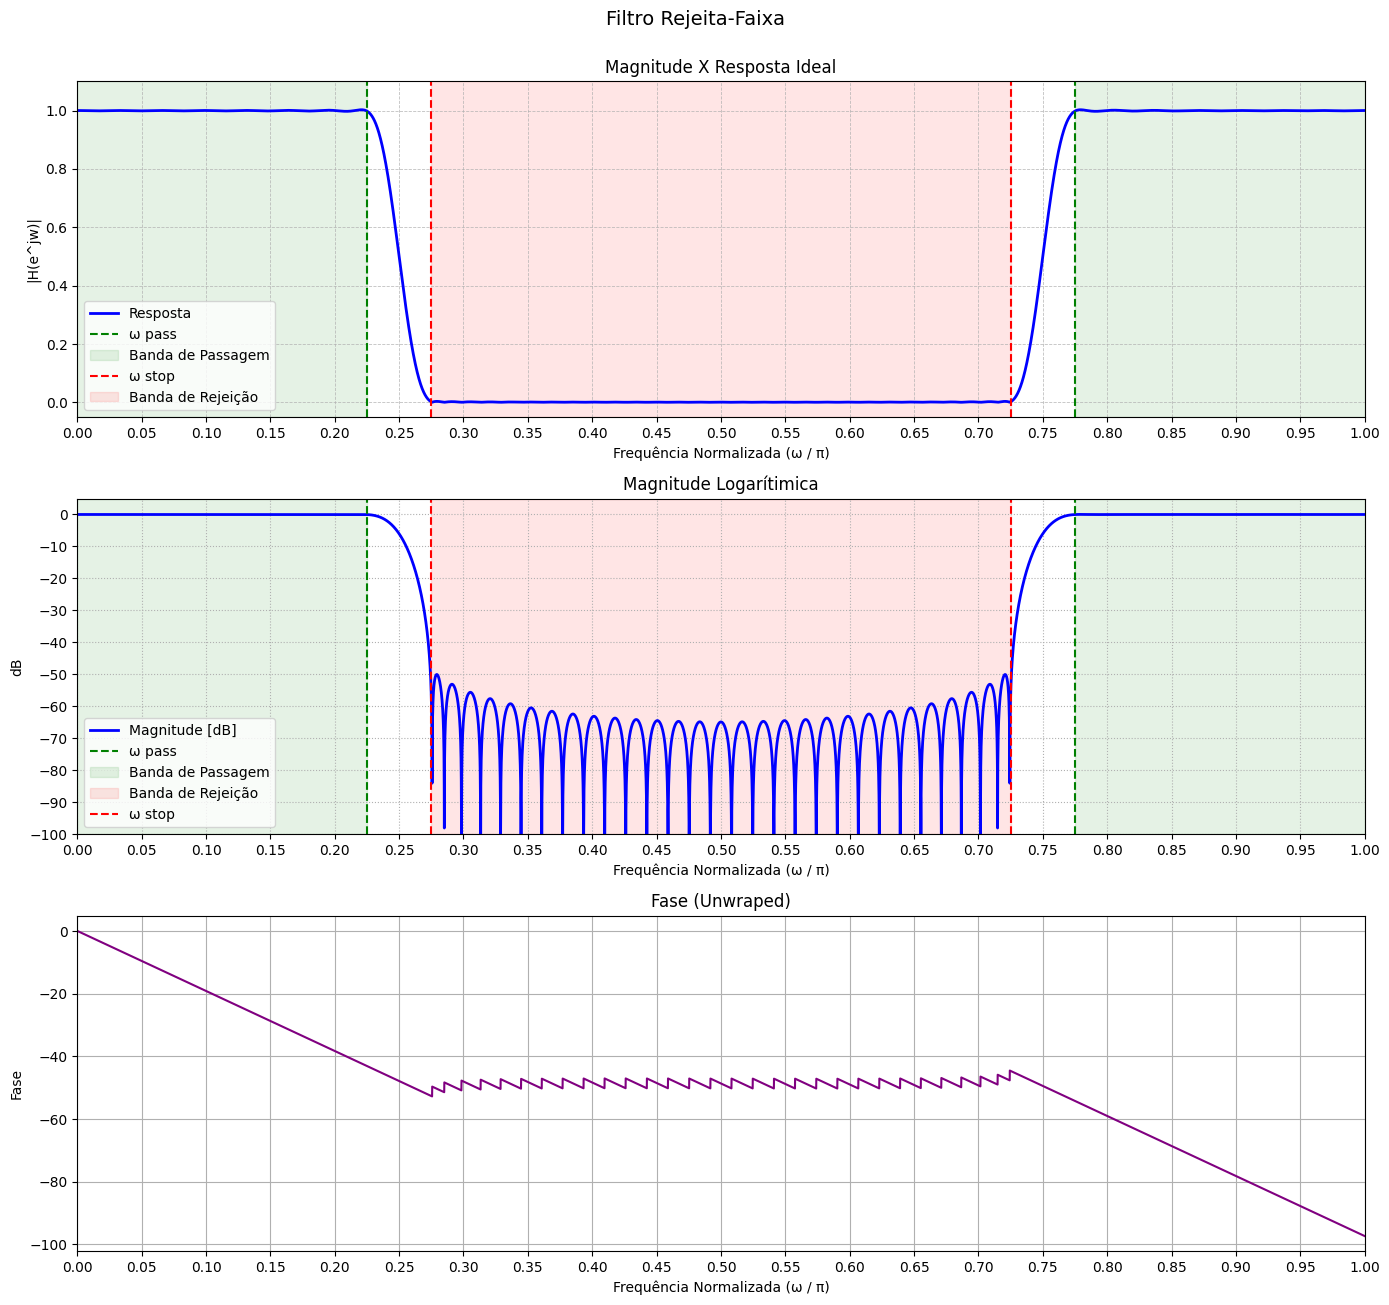

In [68]:
# Upsampling por fator 2
fir_direct_transform2 = np.zeros((M + 1)*2)    
fir_direct_transform2[1::2] = fir_direct

omega_transform2, response_transform2 = freqz(fir_direct_transform2, worN=10192)   
omega_transform2_norm = omega_transform2 / np.pi                                 

plot_transformations_graph(omega_transform2_norm, response_transform2, "Filtro Rejeita-Faixa", False, True)

A transformação $Z^{-1} = z^{-2}$ é equivalente a realizar um *upsampling* no domínio do tempo, ou seja, inserir zeros entre as amostras do filtro original. Essa operação altera a resposta em frequência do filtro, fazendo com que um filtro passa-baixas se transforme em um filtro rejeita-faixas. Isso pode ser observado nos gráficos, onde a a faixa de rejeição agora se localiza nas frequências intermediárias enquanto a faixa de passagem está nas altas e baixas frequências.

Além disso, ocorre a compressão na banda de passagem, então, nesse caso, ela é comprimida por um fator de 2 ($\omega_p/2$) e, pela simetria e periodicidade, ela ocorre novamente em $\pi - \omega_p/2$ 

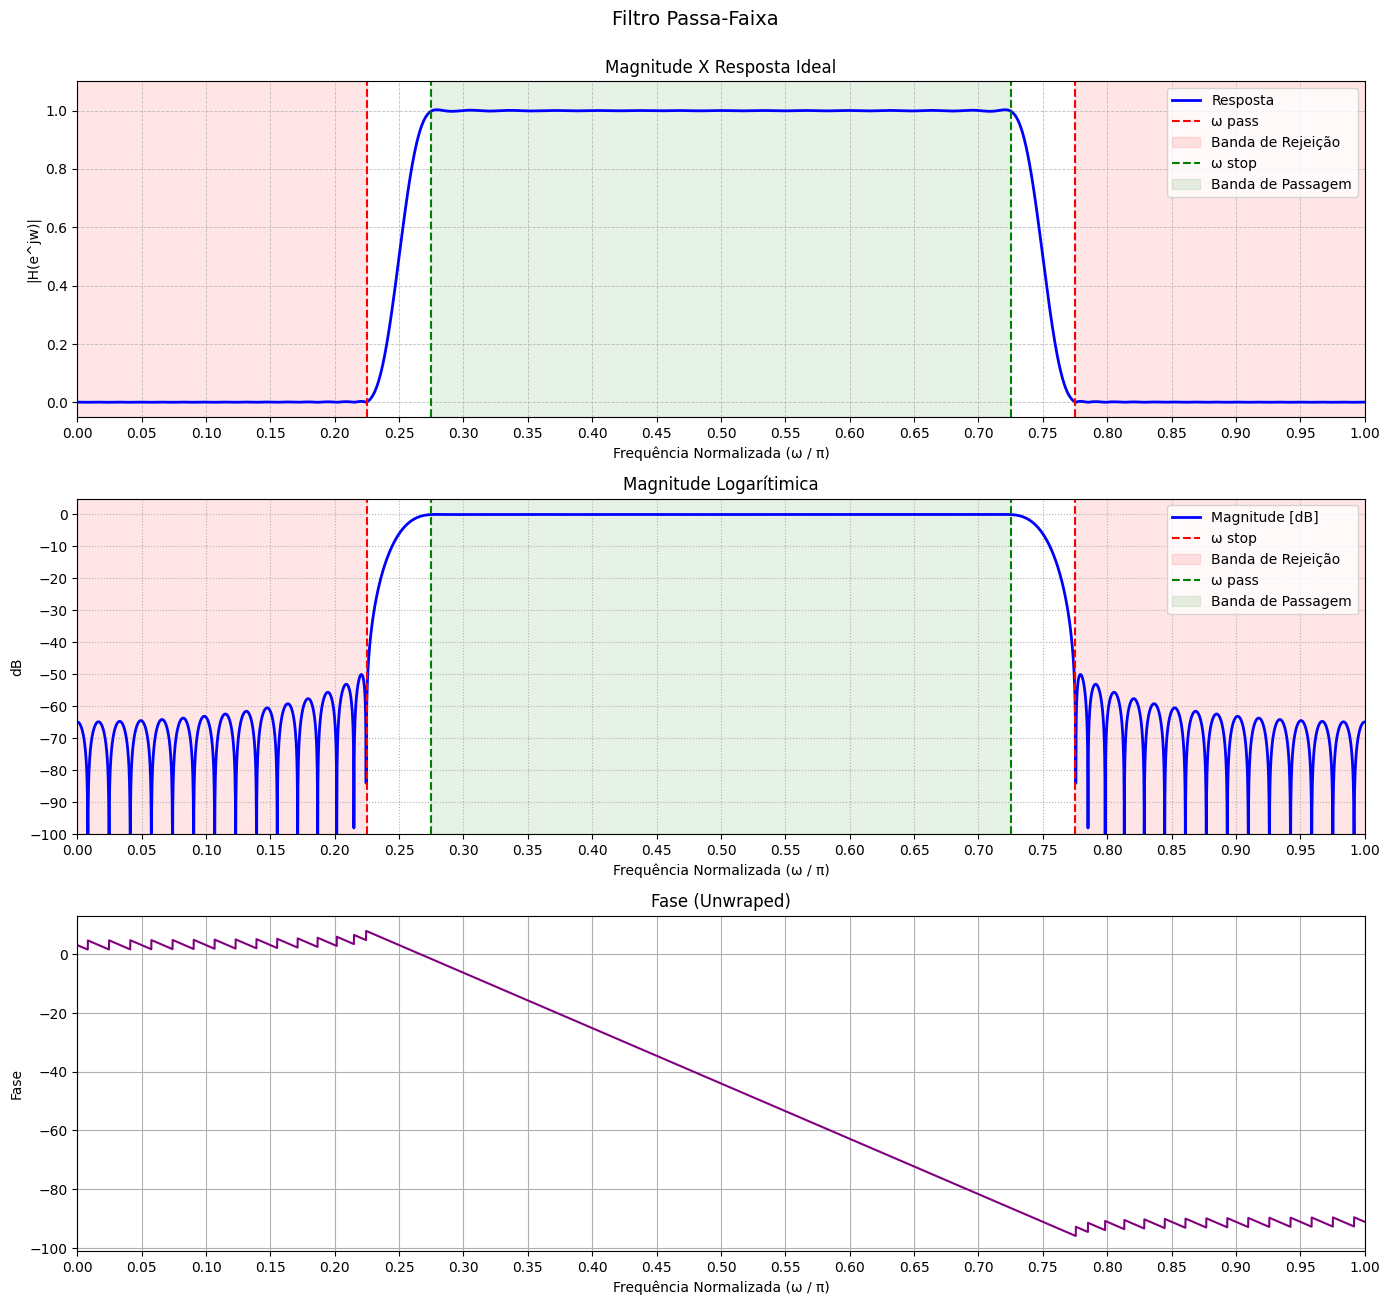

In [69]:
# Upsampling por fator 2 com inversão se coeficientes ímpares
fir_direct_transform3 = np.zeros((M + 1)*2)
fir_direct_transform3[::2] = fir_direct

fir_direct_transform3[::2][1::2] *= -1


omega_transform3, response_transform3 = freqz(fir_direct_transform3, worN=10192)   
omega_transform3_norm = omega_transform3 / np.pi                              

plot_transformations_graph(omega_transform3_norm, response_transform3, "Filtro Passa-Faixa", True, False)

A transformação $Z^{-1} = z^{-2}$ equivale a fazer um *upsampling* no domínio do tempo, ou seja, inserir zeros entre as amostras do filtro original, e também inverter o sinal dos coeficientes de ordem ímpar. Com isso, o filtro passa-baixas  é transformado em um filtro passa-faixas. É possível observar isso nos gráficos, onde agora a banda de passagem foi deslocada para as frequências intemediárias e a banda de rejeição para as altas e baixas frequências.

Além disso, ocorre a compressão e um deslocamento por $\pi$ na frequência. Então, nesse caso, a banda de rejeição é comprimida por um fator de 2 ($\omega_s/2$) e, pela simetria e periodicidade, ela ocorre novamente em $\pi - \omega_s/2$. 